In [ ]:
!pip install pyperch

## Random Hill Climbing Classification

This example demonstrates **Random Hill Climbing (RHC)** using the `Perch` builder API in **pyperch**.  
The builder abstracts away model setup, data loading, and training configuration into a single interface, making it easy to experiment with randomized optimization methods.

**Steps below:**
- Generate a synthetic binary classification dataset  
- Define a small MLP classifier  
- Train using the RHC optimizer
- Visualize the loss curve and accuracy over time

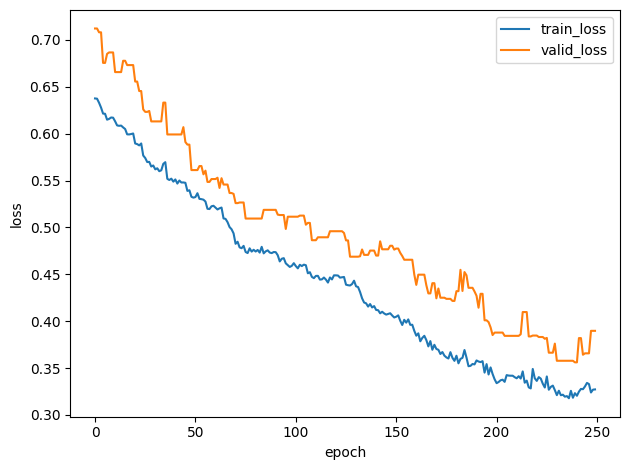

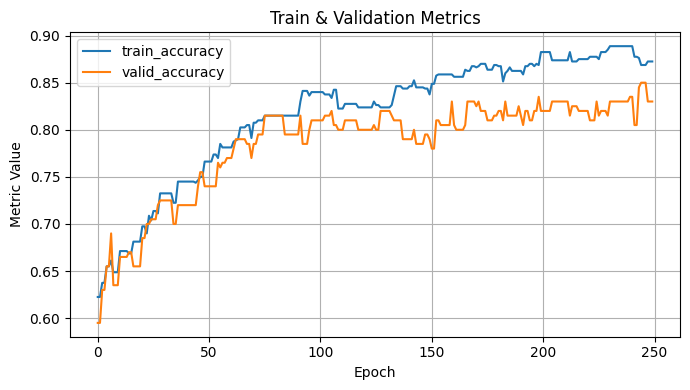

In [4]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.utils import plot_losses, plot_metrics
from pyperch.core.metrics import Accuracy

# -------------------------------------------------------------------
# 1. Reproducibility
# -------------------------------------------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# -------------------------------------------------------------------
# 2. Generate dataset
# -------------------------------------------------------------------
X, y = make_classification(
    n_samples=1000,
    n_features=12,
    n_informative=10,
    n_classes=2,
    random_state=seed,
)

X = X.astype(np.float32)
y = y.astype(np.int64)

# -------------------------------------------------------------------
# 3. Builder version (replaces model + loaders + TrainConfig)
# -------------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=12,
        hidden=[32],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    .optimizer("rhc", step_size=0.05)
    .metrics(Accuracy())
    .data(
        X,
        y,
        batch_size=64,
        valid_split=0.2,
        stratify=True,
        normalize=None,
    )
)

# -------------------------------------------------------------------
# 4. Train
# -------------------------------------------------------------------
trainer, history = perch.train(
    max_epochs=250,
    seed=seed,
    optimizer_mode="per_epoch",
)

# -------------------------------------------------------------------
# 5. Plots
# -------------------------------------------------------------------
plot_losses(history)
plt.show()

plot_metrics(history)
plt.show()

## Random Hill Climbing Regression

This example demonstrates RHC applied to a regression task using the `Perch` builder API. 
Training progress is visualized using the built-in loss and metric plots, with R² used to evaluate predictive performance on both the training and validation splits.

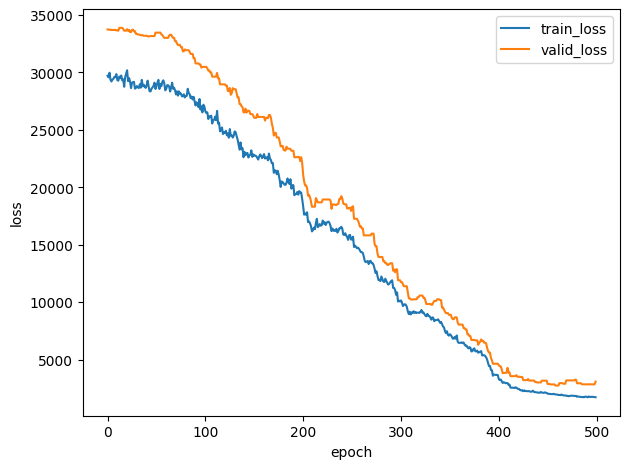

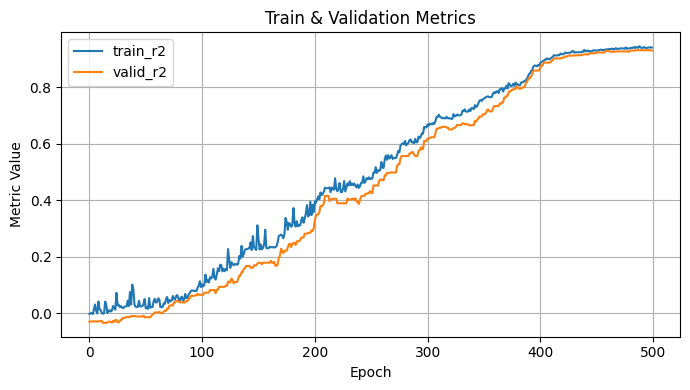

Final train loss: 1752.893817608173
Final valid loss: 3111.6007385253906
Final train R2: 0.9407165857704259
Final valid R2: 0.9299080148751333


In [6]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.core.metrics import MSE, R2
from pyperch.utils import plot_losses, plot_metrics

# -------------------------------------------------------------------
# 1. Reproducibility
# -------------------------------------------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# -------------------------------------------------------------------
# 2. Regression dataset
# -------------------------------------------------------------------
X, y = make_regression(
    n_samples=1000,
    n_features=12,
    n_informative=10,
    noise=0.2,
    random_state=seed,
)

X = X.astype(np.float32)
y = y.reshape(-1, 1).astype(np.float32)  # regression target must be 2D

# -------------------------------------------------------------------
# 3. Builder version (model + optimizer + metrics + data)
# -------------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=12,
        hidden=[32],
        output_dim=1,
        activation="leaky_relu",
        loss_fn=nn.MSELoss(),
    )
    .optimizer("rhc", step_size=0.5)
    .metrics(R2())
    .data(
        X,
        y,
        batch_size=64,
        valid_split=0.2,
        shuffle=True,
        normalize=None,
    )
)

# -------------------------------------------------------------------
# 4. Train
# -------------------------------------------------------------------
trainer, history = perch.train(
    max_epochs=500,
    seed=seed,
    optimizer_mode="per_epoch",
)

# -------------------------------------------------------------------
# 5. Built-in plots
# -------------------------------------------------------------------
plot_losses(history)
plt.show()

plot_metrics(history)
plt.show()

# -------------------------------------------------------------------
# 6. Final metrics
# -------------------------------------------------------------------
print("Final train loss:", history["train_loss"][-1])
print("Final valid loss:", history["valid_loss"][-1])

train_r2 = history["train_metrics"].get("r2")
valid_r2 = history["valid_metrics"].get("r2")

if train_r2:
    print("Final train R2:", train_r2[-1])
if valid_r2:
    print("Final valid R2:", valid_r2[-1])

## Freeze + Optimization Example

This example demonstrates how to combine frozen layers and meta-optimized layers using the `Perch` builder API. 

The first layer is frozen, while the final layer is optimized with RHC. A callback captures the initial frozen weights to verify they do not change during training. Training progress is visualized using the built-in loss and accuracy plots.

Frozen layer unchanged: True


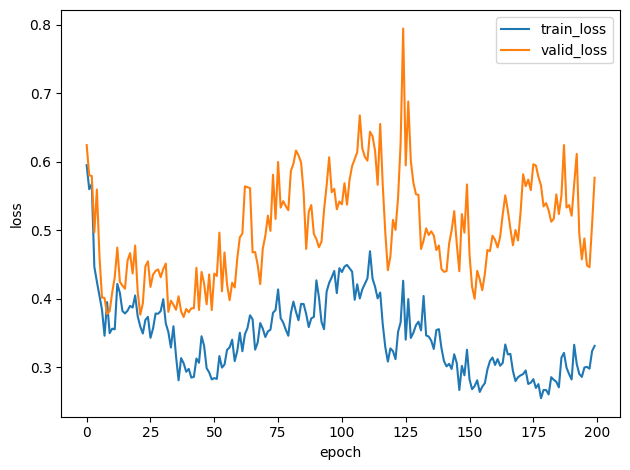

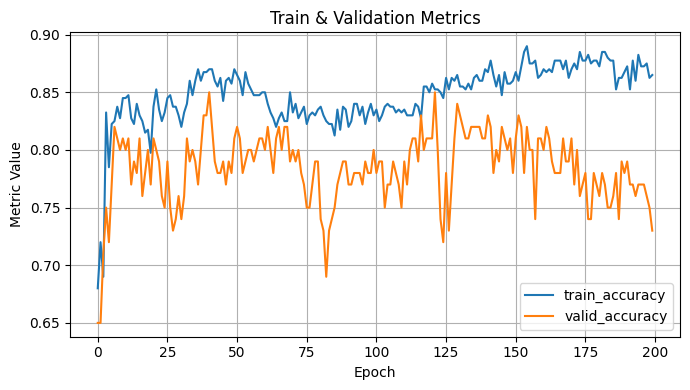

In [8]:
import torch
import numpy as np
from torch import nn
from sklearn.model_selection import train_test_split

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.utils import plot_losses, plot_metrics
from pyperch.core.callbacks import CaptureInitialWeights

# ------------------------------------------------------------
# Dummy dataset
# ------------------------------------------------------------
np.random.seed(42)
torch.manual_seed(42)

X = np.random.randn(500, 10).astype(np.float32)
y = (np.sum(X[:, :3], axis=1) > 0).astype(np.int64)

# ------------------------------------------------------------
# Build experiment with Perch (model + data + freeze + meta)
# ------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=10,
        hidden=[16],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    .freeze("net.0.weight", "net.0.bias")      # frozen layer
    .meta_opt("net.2.weight", "net.2.bias")    # meta (RHC) layer
    .optimizer("rhc", step_size=0.5)
    .metrics("accuracy")
    .data(
        X,
        y,
        batch_size=32,
        valid_split=0.2,
        shuffle=True,
    )
)

# ------------------------------------------------------------
# Capture frozen weights BEFORE training
# ------------------------------------------------------------
cap = CaptureInitialWeights("net.0.weight")

trainer, history = perch.callbacks(cap).train(
    max_epochs=200,
    seed=42,
    optimizer_mode="per_batch",
)

# ------------------------------------------------------------
# Verify freeze
# ------------------------------------------------------------
initial = cap.initial["net.0.weight"]
final = trainer.model.net[0].weight.detach()

unchanged = torch.allclose(initial, final)
print("Frozen layer unchanged:", unchanged)

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
plot_losses(history)
plot_metrics(history)


## Hybrid Gradient + RHC Optimization Example

This example demonstrates hybrid optimization using the `Perch` builder API, where different layers of the same network are trained using different optimization strategies. The first layer is trained using Adam, while the output layer is trained using RHC. 

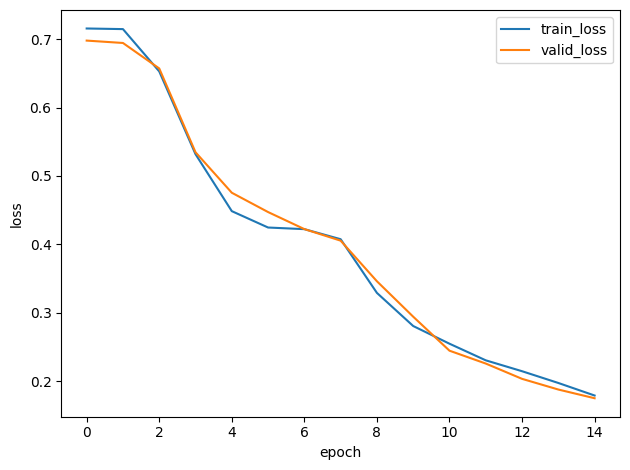

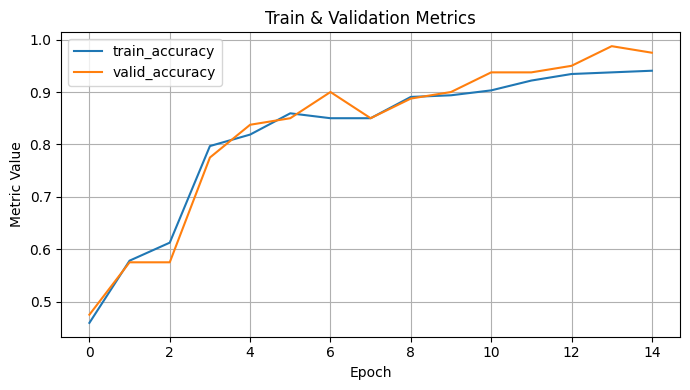

In [10]:
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.utils import plot_losses, plot_metrics

# ------------------------------------------------------------
# Dummy dataset
# ------------------------------------------------------------
np.random.seed(42)
X = np.random.randn(500, 10).astype(np.float32)
y = (np.sum(X[:, :3], axis=1) > 0).astype(np.int64)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------
# Builder
# ------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=10,
        hidden=[16],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    # Adam on first layer
    .grad_opt("net.0.weight", "net.0.bias")
    # RHC on output layer
    .meta_opt("net.2.weight", "net.2.bias")
    .optimizer("rhc", step_size=0.5)
    .torch_optimizer("adam", lr=1e-3)
    .metrics("accuracy")
    .data(X_train, y_train, batch_size=32, valid_split=0.2)
)

trainer, history = perch.train(
    max_epochs=15,
    seed=42,
    optimizer_mode="per_batch",
)

plot_losses(history)
plot_metrics(history)


## Freeze + Hybrid (Gradient + RHC) Optimization

This example demonstrates a freeze + hybrid optimization setup using the `Perch` builder API.  
Different layers are trained using different strategies: the first layer is frozen, the middle layer is trained with gradient descent, and the output layer is optimized using RHC.

### Layer indexing in SimpleMLP

Internally, `SimpleMLP` builds the network as a `torch.nn.Sequential` module where Linear layers and activation functions alternate:
- `net.0` → `Linear(10 → 32)`
- `net.1` → `ReLU`
- `net.2` → `Linear(32 → 16)`
- `net.3` → `ReLU`
- `net.4` → `Linear(16 → 2)`

Activation functions occupy the odd indices and have no trainable parameters. As a result:

```python
.freeze("net.0.weight", "net.0.bias")   # frozen feature layer (net.0 is the first trainable Linear layer)
.grad_opt("net.2.weight", "net.2.bias") # Adam-trained layer (net.2 is the second trainable Linear layer)
.meta_opt("net.4.weight", "net.4.bias") # RHC-trained output layer (net.4 is the output Linear layer)
```


Frozen layer unchanged: True


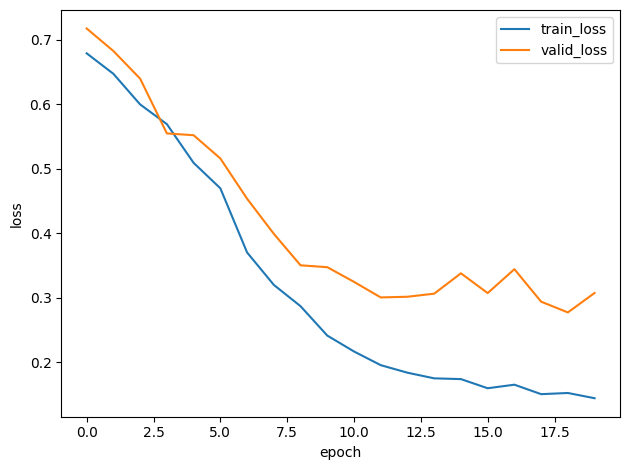

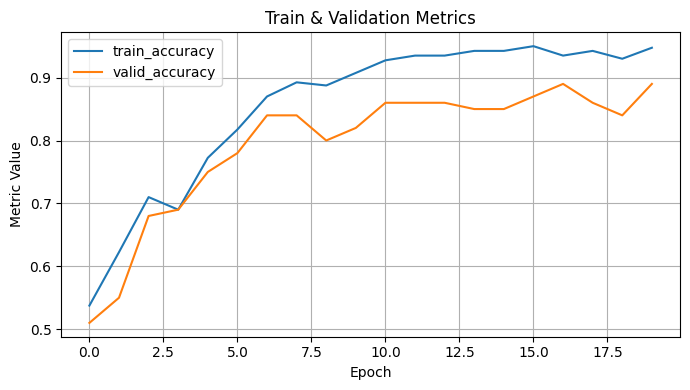

In [12]:
#freeze + hybrid
# ------------------------------------------------------------
# Freeze first layer
# Train middle with Adam
# Train output with RHC
# ------------------------------------------------------------


import numpy as np
import torch
from torch import nn

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.utils import plot_losses, plot_metrics
from pyperch.core.callbacks import CaptureInitialWeights

# ------------------------------------------------------------
# Dummy Classification Dataset
# ------------------------------------------------------------
np.random.seed(42)
torch.manual_seed(42)

X = np.random.randn(500, 10).astype(np.float32)
y = (X[:, :3].sum(axis=1) > 0).astype(np.int64)

# ------------------------------------------------------------
# Freeze + Grad + Meta (Hybrid) Example
# ------------------------------------------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=10,
        hidden=[32, 16], 
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    # ------------------------------
    # Layer modes
    # ------------------------------
    .freeze("net.0.weight", "net.0.bias")        # frozen feature layer
    .grad_opt("net.2.weight", "net.2.bias")      # Adam-trained layer
    .meta_opt("net.4.weight", "net.4.bias")      # RHC-trained output
    # ------------------------------
    # Optimizers
    # ------------------------------
    .optimizer("rhc", step_size=0.5)             # meta optimizer
    .torch_optimizer("adam", lr=1e-3)            # gradient optimizer
    # ------------------------------
    # Metrics + Data
    # ------------------------------
    .metrics("accuracy")
    .data(X, y, batch_size=32, valid_split=0.2)
)

# ------------------------------------------------------------
# Capture frozen weights (verification)
# ------------------------------------------------------------
cap = CaptureInitialWeights("net.0.weight")

trainer, history = perch.callbacks(cap).train(
    max_epochs=20,
    seed=42,
    optimizer_mode="per_batch",
)

# ------------------------------------------------------------
# Verify freeze
# ------------------------------------------------------------
initial = cap.initial["net.0.weight"]
final = trainer.model.net[0].weight.detach()

print("Frozen layer unchanged:", torch.allclose(initial, final))

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
plot_losses(history)
plot_metrics(history)